In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import csv as csv
import matplotlib.patches as patches

In [2]:
!pip install import_ipynb

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 20.9 MB/s eta 0:00:00


In [3]:
#from hilbert import decode, encode
import import_ipynb
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
cd /content/drive/MyDrive/SportsData/Football-LLM

/content/drive/MyDrive/SportsData/Football-LLM


## Import FootballGrid.ipynb

In [5]:
from FootballGrid import *

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
  Preparing metadata (setup.py) ... done
  Created wheel for numpy-hilbert-curve: filename=numpy_hilbert_curve-1.0.1-py3-none-any.whl size=6937 sha256=0a369316e508f6daa20b9df5f8d3fc8383358a16a2f6ddf763b528d606e74bf1
  Stored in directory: /root/.cache/pip/wheels/25/bc/96/2f9acf95bcd2ff7f2a68eae0067ecef5c29a64cb9e44e30208
Successfully built numpy-hilbert-curve


In [6]:
import Metrica_IO as mio

In [13]:
def to_single_playing_direction(home,away,events):
    '''
    Flip coordinates in second half so that each team always shoots in the same direction through the match.
    '''
    for team in [home,away,events]:
        if (team.Period == 2).any():
          second_half_idx = team[team['Period'] == 2].index[0]

          # Select columns ending with 'x' or 'y' (case-insensitive)
          columns = [c for c in team.columns if c[-1].lower() in ['x', 'y']]

          # Flip the coordinates for the second half
          team.loc[second_half_idx:, columns] *= -1
    return home,away,events

In [14]:
DATADIR = '/content/drive/MyDrive/SportsData/'
game_id = 2

events = mio.read_event_data(DATADIR,game_id)

tracking_home = mio.tracking_data(DATADIR,game_id,'Home')
tracking_away = mio.tracking_data(DATADIR,game_id,'Away')
'''
tracking_home = mio.to_metric_coordinates(tracking_home)
tracking_away = mio.to_metric_coordinates(tracking_away)
events = mio.to_metric_coordinates(events)
'''
tracking_home.head()
# 전반, 후반 방향 일치 (후반전 선수 방향 filp)
tracking_home, tracking_away, events = to_single_playing_direction(tracking_home, tracking_away, events)

Reading team: home
Reading team: away


## Home raw data preprocessing

In [15]:
home_10_frames = len(tracking_home['Home_10_x']) - tracking_home['Home_10_x'].isnull().sum()
home_10_data = tracking_home[['Home_10_x', 'Home_10_y']][:home_10_frames]
home_14_data = tracking_home[['Home_14_x', 'Home_14_y']][home_10_frames:]
home_14_data.columns = home_10_data.columns

total_data_10 = pd.concat([home_10_data, home_14_data], axis=0)
home_8_frames = len(tracking_home['Home_8_x']) - tracking_home['Home_8_x'].isnull().sum()
home_8_data = tracking_home[['Home_8_x', 'Home_8_y']][:home_8_frames]
home_13_data = tracking_home[['Home_13_x', 'Home_13_y']][home_8_frames:]
home_13_data.columns = home_8_data.columns

total_data_8 = pd.concat([home_10_data, home_14_data], axis=0)
home_4_frames = len(tracking_home['Home_4_x']) - tracking_home['Home_4_x'].isnull().sum()
home_4_data = tracking_home[['Home_4_x', 'Home_4_y']][:home_4_frames]
home_12_data = tracking_home[['Home_12_x', 'Home_12_y']][home_4_frames:]
home_12_data.columns = home_4_data.columns

total_data_4 = pd.concat([home_4_data, home_12_data], axis=0)
away_22_frames = len(tracking_away['Away_22_x']) - tracking_away['Away_22_x'].isnull().sum()
away_22_data = tracking_away[['Away_22_x', 'Away_22_y']][:away_22_frames]
away_26_data = tracking_away[['Away_26_x', 'Away_26_y']][away_22_frames:]
away_26_data.columns = away_22_data.columns

total_data_22 = pd.concat([away_22_data, away_26_data], axis=0)

In [16]:
tracking_home_temp = tracking_home.copy()

tracking_home_temp[['Home_10_x' ,'Home_10_y']] = total_data_10
tracking_home_temp[['Home_8_x' ,'Home_8_y']] = total_data_8
tracking_home_temp[['Home_4_x' ,'Home_4_y']] = total_data_4
tracking_home = tracking_home_temp.drop(columns = ['Home_12_x', 'Home_12_y', 'Home_13_x', 'Home_13_y', 'Home_14_x', 'Home_14_y'])
tracking_away_temp = tracking_away.copy()

tracking_away_temp[['Away_22_x', 'Away_22_y']] = total_data_22
tracking_away = tracking_away_temp.drop(columns = ['Away_26_x', 'Away_26_y'])
tracking_merge = pd.merge(tracking_home, tracking_away, on='Time [s]', how="left")
tracking_merge.drop(columns=['ball_x_x', 'ball_y_x', 'Period_y'], inplace=True)
tracking_merge = tracking_merge.rename(columns={'Period_x': 'Period', 'ball_x_y': 'ball_x', 'ball_y_y': 'ball_y'})

tracking_merge = tracking_merge.drop(columns = ['ball_x', 'ball_y'])

In [17]:
# Identify player columns and their corresponding 'Unnamed' y-coordinate columns
player_x_columns = [col for col in tracking_merge.columns if "_x" in str(col)]
player_y_columns = [col for col in tracking_merge.columns if "_y" in str(col)]

# Pair players with their x and y coordinate columns
player_coordinates = [(player_x_columns[i], player_y_columns[i]) for i in range(len(player_x_columns))]

# Extract Ball x and y-coordinates

player_coordinates


[('Home_11_x', 'Home_11_y'),
 ('Home_1_x', 'Home_1_y'),
 ('Home_2_x', 'Home_2_y'),
 ('Home_3_x', 'Home_3_y'),
 ('Home_4_x', 'Home_4_y'),
 ('Home_5_x', 'Home_5_y'),
 ('Home_6_x', 'Home_6_y'),
 ('Home_7_x', 'Home_7_y'),
 ('Home_8_x', 'Home_8_y'),
 ('Home_9_x', 'Home_9_y'),
 ('Home_10_x', 'Home_10_y'),
 ('Away_25_x', 'Away_25_y'),
 ('Away_15_x', 'Away_15_y'),
 ('Away_16_x', 'Away_16_y'),
 ('Away_17_x', 'Away_17_y'),
 ('Away_18_x', 'Away_18_y'),
 ('Away_19_x', 'Away_19_y'),
 ('Away_20_x', 'Away_20_y'),
 ('Away_21_x', 'Away_21_y'),
 ('Away_22_x', 'Away_22_y'),
 ('Away_23_x', 'Away_23_y'),
 ('Away_24_x', 'Away_24_y')]

In [18]:
# Prepare a cleaned dataframe with player (x, y) and ball coordinates
coordinate_data = pd.DataFrame({
    player[:-2]: list(zip(tracking_merge[player], tracking_merge[y]))
    for player, y in player_coordinates
})
#skipped Ball
#coordinate_data["Ball"] = list(zip(df_cleaned[ball_x_column].fillna(0), df_cleaned[ball_y_column].fillna(0)))

# Add frame and time for reference
coordinate_data["Period"] = tracking_merge["Period"]
coordinate_data["Time [s]"] = tracking_merge["Time [s]"]

# Display the cleaned coordinate data

last_two_columns = coordinate_data.iloc[:, -2:]  # 마지막 두 컬럼 분리
coordinate_data = coordinate_data.iloc[:, :-2]  # 나머지 컬럼만 남김
coordinate_data.head()

,Home_11,Home_1,Home_2,Home_3,Home_4,Home_5,Home_6,Home_7,Home_8,Home_9,...,Away_15,Away_16,Away_17,Away_18,Away_19,Away_20,Away_21,Away_22,Away_23,Away_24
0,"(0.94275, 0.50413)","(0.64812, 0.28605)","(0.67752, 0.42803)","(0.69882, 0.55606)","(0.64348, 0.76253)","(0.23339, 0.25869)","(0.60269, 0.47397)","(0.58508, 0.53017)","(0.50194, 0.61123)","(0.50637, 0.30137)",...,"(0.32891, 0.81846)","(0.30734, 0.55182)","(0.32235, 0.38954)","(0.36505, 0.31049)","(0.49564, 0.91364)","(0.39812, 0.47218)","(0.43313, 0.31354)","(0.49889, -0.02263)","(0.50177, 0.50145)","(0.49517, 0.36234)"
1,"(0.94275, 0.50413)","(0.64812, 0.28605)","(0.67752, 0.42803)","(0.69882, 0.55606)","(0.64348, 0.76253)","(0.23339, 0.25869)","(0.60269, 0.47397)","(0.58508, 0.53017)","(0.50194, 0.61123)","(0.50637, 0.30137)",...,"(0.32891, 0.81846)","(0.30734, 0.55182)","(0.32235, 0.38954)","(0.36505, 0.31049)","(0.49564, 0.91364)","(0.39812, 0.47218)","(0.43313, 0.31354)","(0.49889, -0.02263)","(0.50177, 0.50145)","(0.49517, 0.36234)"
2,"(0.94275, 0.50413)","(0.64812, 0.28605)","(0.67752, 0.42803)","(0.69882, 0.55606)","(0.64348, 0.76253)","(0.23339, 0.25869)","(0.60269, 0.47397)","(0.58508, 0.53017)","(0.50194, 0.61123)","(0.50637, 0.30137)",...,"(0.32891, 0.81846)","(0.30734, 0.55182)","(0.32235, 0.38954)","(0.36505, 0.31049)","(0.49564, 0.91364)","(0.39812, 0.47218)","(0.43313, 0.31354)","(0.49889, -0.02263)","(0.50177, 0.50145)","(0.49517, 0.36234)"
3,"(0.94275, 0.50413)","(0.64812, 0.28605)","(0.67752, 0.42803)","(0.69882, 0.55606)","(0.64348, 0.76253)","(0.23254, 0.2587)","(0.60269, 0.47397)","(0.58508, 0.53017)","(0.50194, 0.61123)","(0.50637, 0.30137)",...,"(0.32836, 0.81847)","(0.30734, 0.55182)","(0.32235, 0.38954)","(0.36505, 0.31049)","(0.49564, 0.91364)","(0.39812, 0.47218)","(0.43313, 0.31354)","(0.49889, -0.02263)","(0.50177, 0.50145)","(0.49517, 0.36234)"
4,"(0.94275, 0.50413)","(0.64812, 0.28605)","(0.67752, 0.42803)","(0.69882, 0.55606)","(0.64348, 0.76253)","(0.2317, 0.25871)","(0.60269, 0.47397)","(0.58508, 0.53017)","(0.50194, 0.61123)","(0.50637, 0.30137)",...,"(0.32783, 0.81847)","(0.30734, 0.55182)","(0.32235, 0.38954)","(0.36505, 0.31049)","(0.49564, 0.91364)","(0.39812, 0.47218)","(0.43313, 0.31354)","(0.49889, -0.02263)","(0.50177, 0.50145)","(0.49517, 0.36234)"


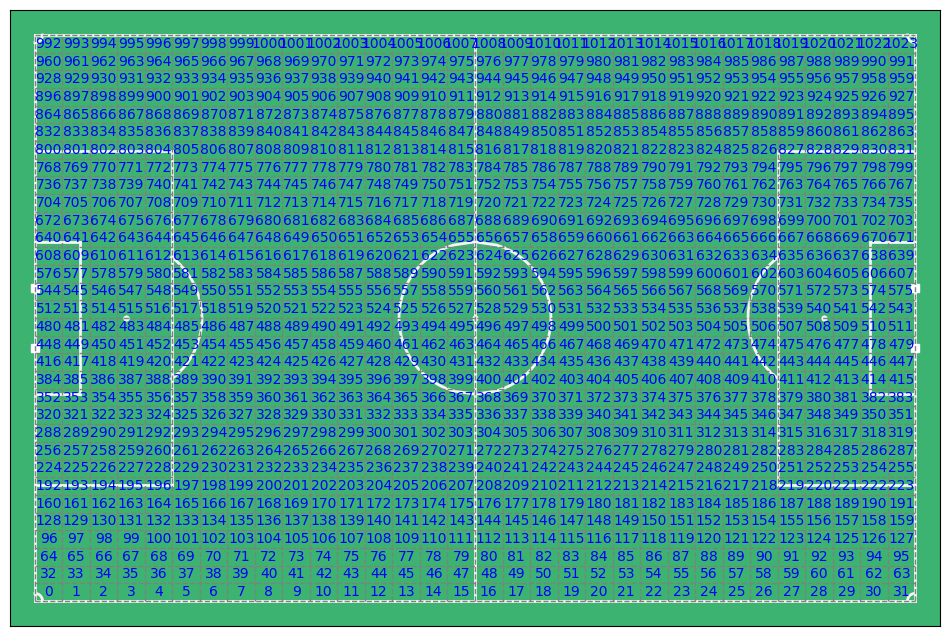

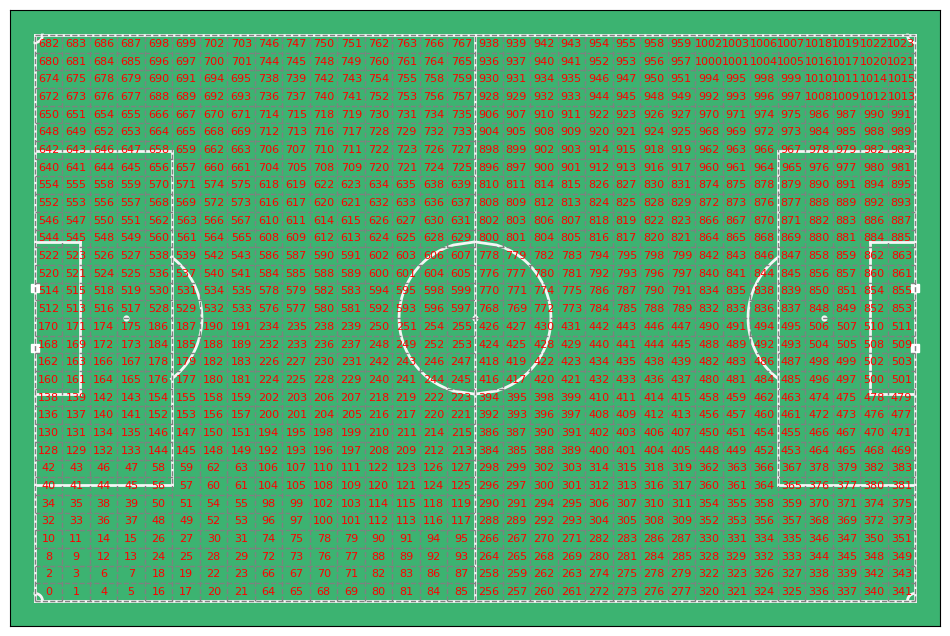

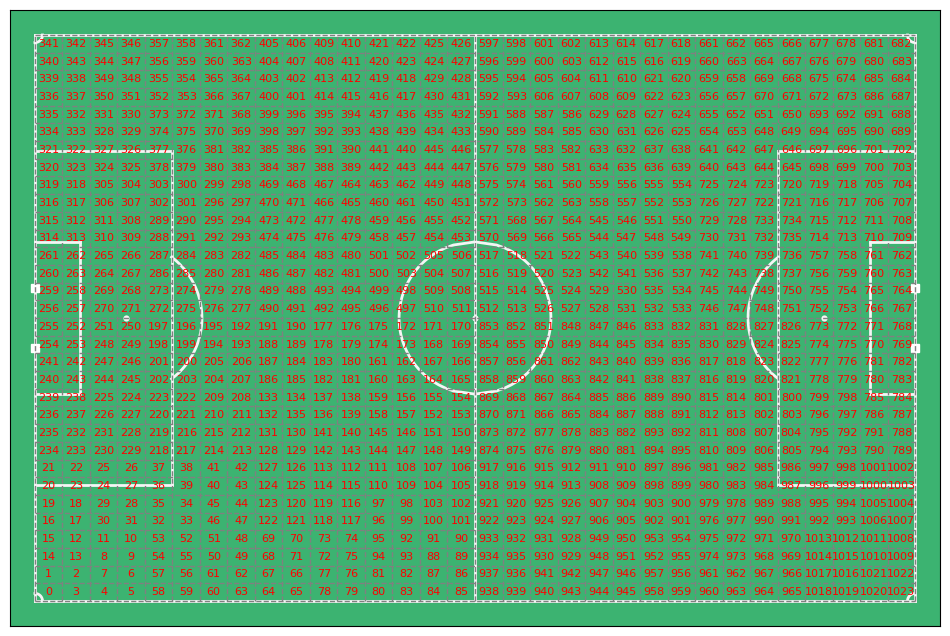

In [20]:
row_wise_order = plot_pitch_with_numbers()
z_order = plot_pitch_with_z_order()
hilbert_order = plot_pitch_with_hilbert_labels()
# return fig, ax, z_order_index
row_wise_order_index = row_wise_order[2]
z_order_index = z_order[2]
hilbert_order_index = hilbert_order[2]

In [21]:
home_columns = [f'Home_{i}' for i in range(1, 12)]
away_columns = [f'Away_{i}' for i in range(15, 26)]
player_columns = home_columns + away_columns
# List of index_order lists
index_orders = [row_wise_order_index, z_order_index, hilbert_order_index]  # Replace with your lists
output_files = ['output_row_wise.csv', 'output_z_order.csv', 'output_hilbert.csv']

In [22]:
from tqdm import tqdm
for i, index_order in enumerate(index_orders):
    df_copy = coordinate_data.copy()  # Create a copy of the DataFrame for each index_order


    # Extract (x, y) from player column (ensure input data matches expected format)
    for player in tqdm(player_columns):
        # Extract (x, y) from player column (ensure input data matches expected format)
        df_copy[player] = df_copy[player].apply(
            lambda coord: get_order(coord[0], coord[1], index_order)
        )

    # Save the transformed DataFrame
    df_copy = pd.concat([last_two_columns, df_copy], axis=0)
    df_copy.to_csv(output_files[i], index=False)
    print(f"File saved: {output_files[i]}")

100%|██████████| 22/22 [15:57<00:00, 43.54s/it]


File saved: output_row_wise.csv


100%|██████████| 22/22 [15:43<00:00, 42.89s/it]


File saved: output_z_order.csv


100%|██████████| 22/22 [28:07<00:00, 76.71s/it]


File saved: output_hilbert.csv


In [25]:
cd /content/drive/MyDrive/SportsData/Football-LLM

/content/drive/MyDrive/SportsData/Football-LLM


In [26]:
git config --global user.email 'csm010311@naver.com'
git config --global user.name 'Csenongmin'
git add Football_indexing.ipynb

SyntaxError: invalid syntax (<ipython-input-26-c5bd82f0ea4f>, line 1)

In [ ]:
git commit -m 'update logic'
git push

[main ea2c035] update code
 1 file changed, 1 insertion(+), 1 deletion(-)
Enumerating objects: 5, done.
Counting objects: 100% (5/5), done.
Delta compression using up to 2 threads
Compressing objects: 100% (3/3), done.
Writing objects: 100% (3/3), 995 bytes | 199.00 KiB/s, done.
Total 3 (delta 2), reused 0 (delta 0), pack-reused 0
remote: Resolving deltas: 100% (2/2), completed with 2 local objects.
To https://github.com/Csenongmin/Football-LLM.git
   19f1e62..ea2c035  main -> main
